In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
title_basics = pd.read_csv('./Data/imdb.title.basics.csv.gz')
title_ratings = pd.read_csv("./Data/imdb.title.ratings.csv.gz")
movie_budgets = pd.read_csv('./Data/tn.movie_budgets.csv.gz')

In [3]:
title_basics.rename(columns = {'primary_title':'movie'}, inplace = True)
title_basics.drop(columns = ["original_title","runtime_minutes"], inplace=True)

In [4]:
title_basics['genres'].isna().sum()/146144*100

3.7004598204510617

In [5]:
title_basics.dropna(subset= ['genres'], inplace = True)

In [6]:
# change release date to date-time
movie_budgets['release_date'] = pd.to_datetime(movie_budgets['release_date'])

In [7]:
# change production_budget, domestic_gross, and worldwide_budget to integers
movie_budgets['production_budget'] = movie_budgets['production_budget'].replace('[\$,]', '', regex=True).astype(float)
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].replace('[\$,]', '', regex=True).astype(float)
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)

In [8]:
movie_budgets.drop(columns = ["id"], inplace=True)
# drop rows where worldwide_gross or production_budget is 0
movie_budgets = movie_budgets[movie_budgets.worldwide_gross != 0]
movie_budgets = movie_budgets[movie_budgets.production_budget != 0]

In [9]:
# add a profit column to movie_budgets
movie_budgets['profit'] = movie_budgets['worldwide_gross'] - movie_budgets['production_budget']

In [10]:
# calculate profit in millions
movie_budgets['profit_million']=(movie_budgets['profit']/1000000)

In [11]:
# calculate production budget in millions
movie_budgets['production_budget_million']=(movie_budgets['production_budget']/1000000)

In [12]:
# add a column ROI calculating the return on investment
movie_budgets['ROI'] = (movie_budgets['profit'] / movie_budgets['production_budget']) * 100
# round ROI to 2 decimal places
movie_budgets = movie_budgets.round({'ROI': 2})

In [13]:
# add a column for movie year
movie_budgets['year'] = pd.DatetimeIndex(movie_budgets['release_date']).year

In [14]:
movie_budgets.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,profit_million,production_budget_million,ROI,year
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,2351.345279,425.0,553.26,2009
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,635.063875,410.6,154.67,2011
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,-200.237650,350.0,-57.21,2019
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09,1072.413963,330.6,324.38,2015
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,9.997217e+08,999.721747,317.0,315.37,2017


# Merge Data Tables

In [15]:
# merge title_basics and title_ratings on tconst
imdb_data = pd.merge(title_basics, title_ratings, how = 'inner', on = 'tconst')
imdb_data.head()

,tconst,movie,start_year,genres,averagerating,numvotes
0,tt0063540,Sunghursh,2013,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,2019,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,2018,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,2018,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy",6.5,119


In [16]:
# merge imdb_data with movie_budgets
mdf = pd.merge(imdb_data, movie_budgets, how = 'inner', on = 'movie')

In [17]:
#move the movies with the most votes on imdb up to top
mdf=mdf.sort_values(by='numvotes', ascending = False)

In [18]:
mdf['same_year']= mdf['start_year']-mdf['year']
mdf = mdf.loc[mdf['same_year']== 0]

In [19]:
mdf = mdf.drop_duplicates(subset='movie')
mdf.drop(columns = ["tconst"], inplace=True)

In [20]:
mdf["genres"] = mdf["genres"].apply(lambda x: x.split(",") if type(x) == str else x)

In [21]:
# filter for movies released after 1990 
mdf = mdf.loc[mdf['year'] >= 2010]

In [22]:
#explode the genres
mdf2 = mdf.explode('genres')

In [23]:
mdf2['genres'].unique()

array(['Action', 'Adventure', 'Sci-Fi', 'Thriller', 'Drama', 'Western',
       'Biography', 'Crime', 'Mystery', 'Comedy', 'Family', 'Fantasy',
       'Animation', 'Romance', 'Music', 'History', 'Horror', 'Sport',
       'War', 'Musical', 'Documentary'], dtype=object)

In [24]:
#removed 'The Gallows' as an outlier for the return on investmest
no_gallows = mdf2.drop(index = 1722).sort_values(by="ROI",ascending = False)

In [25]:
sorted_genres2 = no_gallows.groupby(["genres"], as_index=False).mean().sort_values(by = "ROI", ascending=False)

top5genres_v2 = list(sorted_genres2['genres'].values[0:5])
top5genres_v2

['Horror', 'Mystery', 'Thriller', 'Sci-Fi', 'Animation']

In [26]:
sorted_genres2

,genres,start_year,averagerating,numvotes,production_budget,domestic_gross,worldwide_gross,profit,profit_million,production_budget_million,ROI,year,same_year
11,Horror,2014.167785,5.708054,77185.268456,2.051299e+07,3.630081e+07,7.965158e+07,5.913859e+07,59.138593,20.512987,698.902752,2014.167785,0.0
14,Mystery,2014.200000,6.190435,135118.060870,2.644637e+07,4.246262e+07,9.798276e+07,7.153639e+07,71.536385,26.446371,598.706087,2014.200000,0.0
18,Thriller,2013.753247,6.129004,133254.857143,3.568663e+07,4.924466e+07,1.279535e+08,9.226690e+07,92.266902,35.686635,419.959437,2013.753247,0.0
16,Sci-Fi,2014.388889,6.565873,286807.888889,9.956806e+07,1.329984e+08,3.647116e+08,2.651435e+08,265.143504,99.568056,283.657778,2014.388889,0.0
2,Animation,2014.193878,6.574490,128583.132653,1.001939e+08,1.407021e+08,3.887555e+08,2.885616e+08,288.561604,100.193878,278.690204,2014.193878,0.0
15,Romance,2013.072626,6.338547,82429.480447,2.310958e+07,3.410309e+07,7.047518e+07,4.736560e+07,47.365597,23.109581,267.470168,2013.072626,0.0
12,Music,2013.723404,6.389362,69891.170213,1.812872e+07,3.564235e+07,7.776171e+07,5.963299e+07,59.632989,18.128723,261.097021,2013.723404,0.0
3,Biography,2014.784615,7.051538,113389.415385,2.651900e+07,4.041363e+07,8.309290e+07,5.657390e+07,56.573903,26.519000,248.377846,2014.784615,0.0
7,Drama,2013.860360,6.596396,106750.448949,2.838700e+07,3.581019e+07,7.877166e+07,5.038466e+07,50.384662,28.386996,238.584444,2013.860360,0.0
4,Comedy,2013.627083,6.240625,98136.629167,4.240746e+07,6.237079e+07,1.424374e+08,1.000299e+08,100.029917,42.407458,228.190208,2013.627083,0.0


In [28]:
nsort = sorted_genres2[['genres', 'ROI']]
nsort

,genres,ROI
11,Horror,698.902752
14,Mystery,598.706087
18,Thriller,419.959437
16,Sci-Fi,283.657778
2,Animation,278.690204
15,Romance,267.470168
12,Music,261.097021
3,Biography,248.377846
7,Drama,238.584444
4,Comedy,228.190208


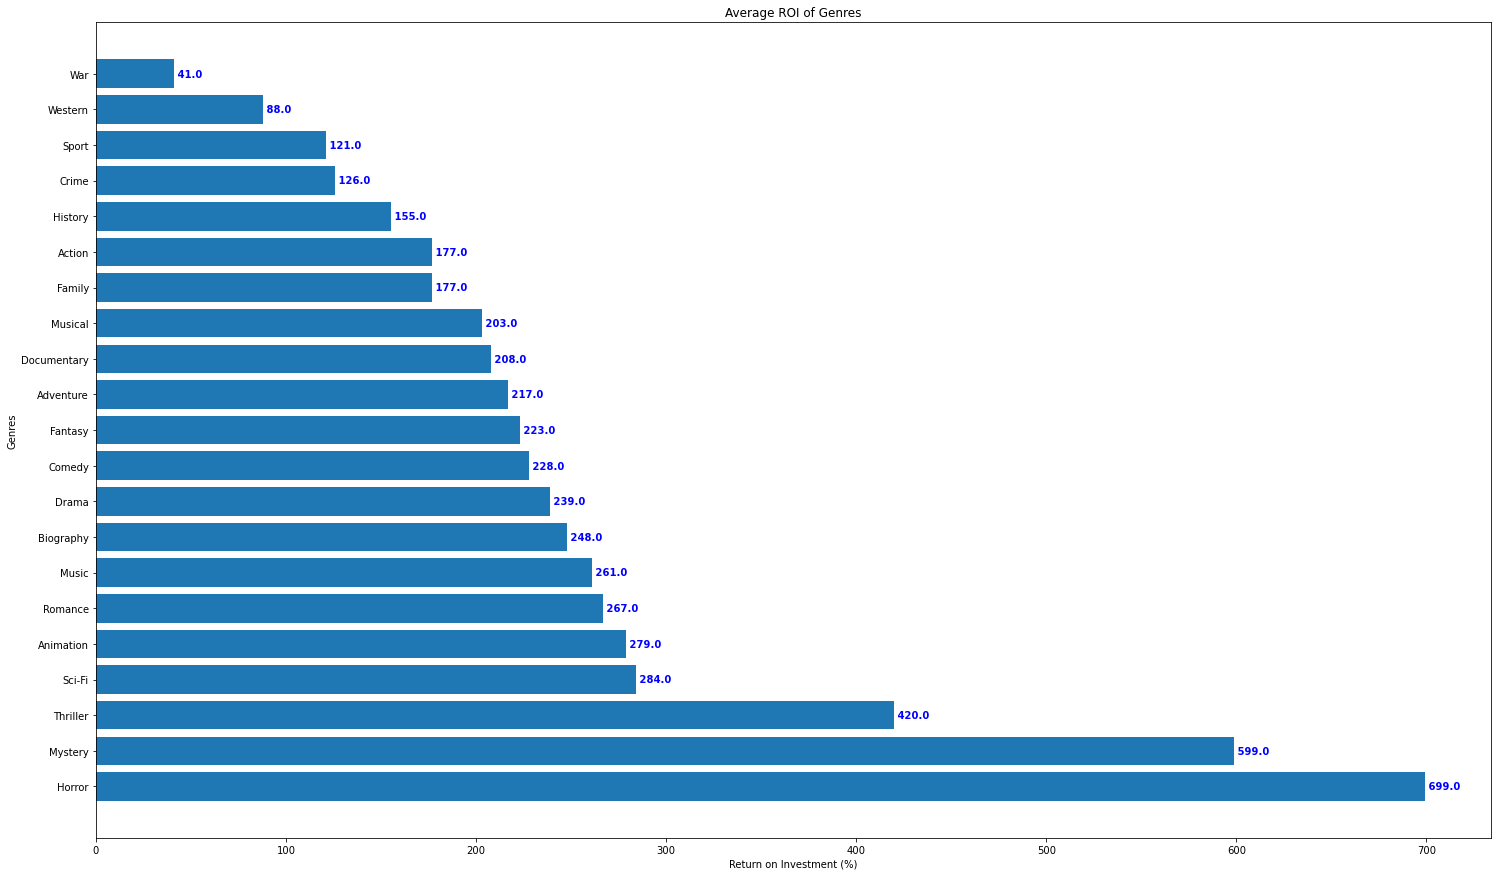

In [46]:
fig, ax = plt.subplots(figsize=(25, 15))
x = nsort['genres']
y = nsort['ROI']
y = y.round()
ax.barh(x, y)
ax.set_title('Average ROI of Genres')
ax.set_xlabel('Return on Investment (%)')
ax.set_ylabel('Genres')
for i, v in enumerate(y):
    ax.text(v, i, " "+str(v), color='blue', va='center', fontweight='bold')